# Run `ClearPath_base.ipynb' first

# ==========
# = Iteration #1 =
# ==========

## Stage 1: Planning
The tasks for this stage are:
1. Compose the project team
2. Set the research question
3. Schedule all review meeting to ensure iterations are time-boxed.

### 1.1.1. Compose the project team
The project team and Clinical Review Board are CMI and CB.

### 1.1.2. Set the research question
The research question is:

_What is the apparent patient process of HbA1c test and prescriptions, following diagnosis of Type 2 Diabetes?_

HbA1c test values will be represented on a Red-Amber-Yellow-Green scale, and only a sample of the most-common prescription will be explicitly named.

### 1.1.3. Schedule all review meeting to ensure iterations are time-boxed
CMI and CB will meet in their regular Thursday-morning meeting.

## Stage 2: Extraction
This tasks for this stage are:
1. Gather knowledge and insight into the processes under study and the data-generating mechanisms.
2. Obtain data for processing

### 1.2.1. Gather knowledge and insight into the processes under study and the data-generating mechanisms.
Regarding the processes under study, I, the modeller, discuss the project during weekly meetings with an experienced GP who is a professor of primary medical care.
Regarding data-generating mechanisms, I, the modeller, have gathered knowledge from over half a decade experience collaborating with clinicians and patients on research projects about electronic healthcare 
records. 

### 1.2.2. Obtain data for processing
Data have been obtain by agreement via Connected Bradford. Data are queryable via this Jupyter notebook on the GoogleCloudPlatform using AI Vertex Workbench.

Install R packages.

In [1]:
#remotes::install_version("<name>", "<version>")
#install.packages("<name>", dependencies = TRUE, repos='http://cran.rstudio.com/')

#remotes::install_version("dbplyr", "2.3.4")
#library(dbplyr)
#available.packages()['dbplyr',]

In [2]:
#######################
## Install packages. ##
#######################
library( pacman )
pacman::p_load( bigrquery, tidyverse, readr, bupaR, bupaverse, heuristicsmineR, arulesSequences, tidytext, TraMineR, TraMineRextras, gridExtra )

Set and load requisites.

In [5]:
##############################
## Set and load requisites. ##
##############################

# Setup connection to GCP.
project_id = "yhcr-prd-phm-bia-core"
con <- DBI::dbConnect( drv = bigquery(), project = project_id ) %>% suppressWarnings()

# Define R tibbles from GCP tables.
#r_tbl_srcode <- dplyr::tbl( con, dbplyr::in_schema( sql( "CB_FDM_PrimaryCare_V7" ), sql( "tbl_srcode" ) ) )
r_tbl_srcode <- dplyr::tbl( con, "CB_FDM_PrimaryCare_V7.tbl_srcode" )
r_tbl_BNF_DMD_SNOMED_lkp <- dplyr::tbl( con, "CB_LOOKUPS.tbl_BNF_DMD_SNOMED_lkp" )
r_tbl_srprimarycaremedication <- dplyr::tbl( con, "CB_FDM_PrimaryCare_V7.tbl_srprimarycaremedication" )
r_tbl_srappointment <- dplyr::tbl( con, "CB_FDM_PrimaryCare_V7.tbl_srappointment" )

# Clinical code lists (BNF, SNOMED-CT, etc).
codes_SNOMED_diagnoses_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-dmtype2_cod-20200812.csv'),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_test_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-glycated-haemoglobin-hba1c-tests-3e5b1269.csv'),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_BNF_meds_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-bnf-section-61-drugs-for-diabetes-207573b7.csv'),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
names_meds_of_interest <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_meds_of_interest ) %>%
    dplyr::select( DMplusD_ProductDescription )
codes_BNF_metformin <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-metformin-bnf-0601022b0-and-child-bnf-codes-only-43e7d87e.csv'),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
names_metformin_meds <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_metformin ) %>%
    dplyr::select( DMplusD_ProductDescription )

# Study start date
date_study_start <- lubridate::ymd('2018-06-01')
date_study_end <- lubridate::ymd('2020-12-31')

# Duration of months after the first prescription that we ignore before studying patterns.
pattern_delay_months <- 0

# Threshold value for the test, which in this case is HbA1c.
val_test_threshold <- 48

# Set values for meaningful changes in the values of the test.
val_meaningful_test_improvement <- -10
val_meaningful_test_disimprovement <- 10

# Set window within which to search for repeated (but not repeat) prescriptions.
window_repeated_prescription_months <- 3

# Set number of tests, treatments, or iterations after diagnosis that should be tracked.
n_iterations <- 5

# Set ordering of factors labels for the event variable.
df_event_factor <-
    data.frame(
        event_fct_order =
            factor(
                c( "Test Status = Red", "Test Status = Amber",  "Test Status = Yellow", "Test Status = Green", "Metformin", "Gliclazide", "Empagliflozin", "Other Rx")
                ,levels = c( "Test Status = Red", "Test Status = Amber",  "Test Status = Yellow", "Test Status = Green", "Metformin", "Gliclazide", "Empagliflozin", "Other Rx")
            )
        ,event_colours_order = c( "firebrick1", "darkorange", "gold", "limegreen", "dodgerblue", "plum1", "slateblue1", "grey" )
    )

Define cohort.

In [6]:
####################
## Define cohort. ##
####################
# The cohort is defined as records that include a diagnosis for Type 2 Diabetes Mellitus (T2DM)
# and a prescription for metformin as the only diabetic medication for the first prescription.
# The following queries create this list of records that are within the Connected Bradford primary
# care table.
#
# Select records from primary care that have a clinical code for a T2DM diagnosis. Include a column
# showing the earliest date of diagnosis. Filter for within the study period.
#
ppl_with_T2DM_diagnoses <-
    r_tbl_srcode %>%
    dplyr::filter( snomedcode %in% codes_SNOMED_diagnoses_of_interest ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::summarise( date_diagnosis = min( dateevent, na.rm = TRUE ) ) %>%
    dplyr::select( person_id, date_diagnosis ) %>%
    dplyr::filter( dplyr::between(date_diagnosis, date_study_start, date_study_end) ) %>%
    dplyr::ungroup()

Retrieve dates of prescriptions that followed diagnosis.

In [7]:
qry_log_prescription <-
########################################################################################################
## Select list of person IDs that have a metformin prescription as their first diabetic prescription. ## 
########################################################################################################
    # Select from the medication table the records for those patients who have a diagnosis.
    ppl_with_T2DM_diagnoses %>%
    dplyr::left_join(r_tbl_srprimarycaremedication, by = join_by( person_id ) ) %>%
    # Select every record that has a prescription for any diabetes medication.
    dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
    # Extract the first prescription.
    dplyr::group_by( person_id ) %>%
    dplyr::summarise( date_first_prescription = min( dateevent, na.rm = TRUE ) ) %>%
    # Join to the original table to get the name of the medication.
    dplyr::left_join( r_tbl_srprimarycaremedication, by = join_by( person_id, date_first_prescription == dateevent ) ) %>%
    dplyr::select( person_id, date_first_prescription, nameofmedication, isrepeatmedication, medicationquantity, medicationdosage ) %>%
    dplyr::distinct() %>%
    # Use an inner join to filter these first prescriptions for the metformin medications, only.
    dplyr::inner_join( names_metformin_meds, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
    dplyr::distinct() %>%
    # Select the required fields.
    dplyr::select( person_id, date_first_prescription ) 

##############################################################
## Retrieve dates of prescriptions that followed diagnosis. ##
##############################################################
# Note: If more than one medication was prescribed on the same day, then they are considered
#       to be the i-th and i+1-th prescription, ordered alphabetically. This will manifest
#       as two of the `date_next_prescription_*` fields having the same date, and one of the
#       `interval_prescp_to_prescp_*` fields correctly showing 0 days between the prescriptions.
#
qry_log_prescription_longFormat <-
    qry_log_prescription %>%
    # Join to medications table.
    dplyr::inner_join( r_tbl_srprimarycaremedication, by = join_by( person_id ) ) %>%
    # Select every record that has a prescription for any diabetes medication.
    dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
    # Extract the required fields.
    dplyr::select( person_id, dateevent, nameofmedication, date_first_prescription ) %>%
    # Filter for tests that were done after the pattern start date.
    dplyr::group_by( person_id ) %>%
    dplyr::filter(
        dateevent > sql(paste0( 'DATETIME_ADD( date_first_prescription, INTERVAL ', pattern_delay_months, ' MONTH )') )
    ) %>% 
    # Remove `date_first_prescription` because it is no longer needed.
    dplyr::select( - date_first_prescription ) %>%
    dplyr::distinct() %>%
    # Filter for however many subsequent test you want, then number them.
    dbplyr::window_order( person_id, dateevent, nameofmedication ) %>% 
    dplyr::filter( row_number() <= n_iterations ) %>% 
    dplyr::mutate( event_name = paste0( "prescription_", row_number() ) ) %>% 
    # Rename columns (the hacky way).
    dplyr::mutate(
        start_dttm = dateevent
        ,event_value = nameofmedication
    ) %>%
    dplyr::select( -c( dateevent, nameofmedication ) ) %>% 
    # Set the end time each prescription as the start time of the previous one.
    dplyr::group_by( person_id ) %>%
    dbplyr::window_order( person_id, start_dttm ) %>%
    dplyr::mutate(
        end_dttm = dplyr::if_else( event_name == "diagnosis", start_dttm, lead( start_dttm ) )
    ) %>%
    dplyr::mutate_at(
        .vars = vars( end_dttm )
        ,.funs = funs( dplyr::if_else(is.na(end_dttm), start_dttm, end_dttm) )
    ) %>%
    dplyr::ungroup() %>%
    suppressWarnings()

df_log_prescription_wideFormat <-
    qry_log_prescription_longFormat %>%
    dplyr::mutate_at( .vars = vars(event_name), .funs = funs( gsub("prescription_", "prescp", . ) ) ) %>%
    tidyr::pivot_wider(
        names_from = event_name
        ,values_from = c( start_dttm, event_value )
        , names_sort = TRUE) %>%
    dplyr::ungroup() %>%
    suppressWarnings()

Retrieve dates of tests that followed diagnosis.

In [8]:
# Retrieve the test result immediately before diagnosis.
test_value_before_diagnosis <-
    r_tbl_srcode %>%
    dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest) %>%
    dplyr::select( person_id, dateevent, numericvalue ) %>%
    dplyr::inner_join( ppl_with_T2DM_diagnoses, by = join_by( person_id ) ) %>%
    # Choose tests before the date of diagnosis.
    dplyr::filter( dateevent <= date_diagnosis) %>%
    # Filter out test scores of 0, which are expected to be data entry anomalies, given my selection of columns.
    dplyr::filter( numericvalue != "0" ) %>%
    # Filter for the latest test before diagnosis.
    dplyr::group_by( person_id ) %>%
    dplyr::filter( dateevent == max( dateevent ) ) %>%
    # Filter for the largest score because, sometimes, a patient has two tests on the same latest date, one of which seems spuriously low.
    dplyr::filter( as.numeric(numericvalue) == max( as.numeric(numericvalue) ) ) %>%
    dplyr::ungroup() %>%
    # Tidy up the selection.
    dplyr::select( - date_diagnosis ) %>%
    dplyr::distinct()


######################################################
## Retrieve dates of tests that followed diagnosis. ##
######################################################
qry_log_test_longFormat <- 
    r_tbl_srcode %>%
    # Filter records for only those that refer to the test of interest.
    dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest ) %>% 
    # Filter for only those patients that we already identified in our prescription table. Include the date of first prescripion.
    dplyr::inner_join( qry_log_prescription %>% dplyr::select( person_id, date_first_prescription )
                      ,by = join_by( person_id )
    ) %>%
    # Extract the required fields.
    dplyr::select( person_id, dateevent, numericvalue, date_first_prescription ) %>%
    # Filter out test scores of 0, which are expected to be data entry anomalies, given my selection of columns.
    dplyr::filter( numericvalue != "0" ) %>%
    # Filter for tests that were done after the pattern start date.
    dplyr::group_by( person_id ) %>%
    dplyr::filter(
        dateevent > sql(paste0( 'DATETIME_ADD( date_first_prescription, INTERVAL ', pattern_delay_months, ' MONTH )') )
    ) %>%
    dplyr::ungroup() %>%
    # Remove `date_first_prescription` because it is no longer needed.
    dplyr::select( - date_first_prescription ) %>% 
    # Filter for however many subsequent test you want, then number them.
    dplyr::distinct() %>%
    dplyr::group_by( person_id ) %>%
    dbplyr::window_order( person_id, dateevent ) %>%
    dplyr::filter( row_number() <= n_iterations ) %>%
    dplyr::mutate( event_name = paste0( "test_", row_number() ) ) %>%
    # Rename columns (the hacky way).
    dplyr::mutate(
        start_dttm = dateevent
        ,event_value_numeric = numericvalue
    ) %>% 
    dplyr::select( -c( dateevent, numericvalue ) ) %>%
    # Include each person's date of diagnosis and test result just before diagnosis.
    dplyr::collect() %>%
    dplyr::group_modify(~ add_row( .x, .before = 0 ), .by = person_id ) %>%
    dplyr::left_join( ppl_with_T2DM_diagnoses %>% collect(), by = join_by( person_id ) ) %>% 
    dplyr::left_join( test_value_before_diagnosis %>% collect(), by = join_by( person_id ) ) %>%
    dplyr::mutate(
        start_dttm = if_else( is.na( start_dttm ), date_diagnosis , start_dttm )
        ,event_name = if_else( is.na( event_name ), "diagnosis", event_name )
        ,event_value_numeric = if_else( is.na( event_value_numeric ), numericvalue, event_value_numeric )
    ) %>%
    dplyr::select( - c( date_diagnosis, numericvalue, dateevent ) ) %>%
    # Set the end time each test as the start time of the previous one.
    dplyr::group_by( person_id ) %>%
    dplyr::mutate(
        end_dttm = dplyr::if_else( event_name == "diagnosis", start_dttm, lead( start_dttm ) )
    ) %>%
    dplyr::mutate_at(
        .vars = vars( end_dttm )
        ,.funs = funs( dplyr::if_else(is.na(end_dttm), start_dttm, end_dttm) )
    ) %>%
    dplyr::mutate_at( .vars = vars( event_value_numeric ), .funs = funs( as.numeric ) ) %>%
    dplyr::mutate(
        event_value = dplyr::case_when(
            event_value_numeric > 70 ~ "Test Status = Red"
            ,event_value_numeric > 58  ~ "Test Status = Amber"
            ,event_value_numeric > 48 ~ "Test Status = Yellow"
            ,TRUE ~ "Test Status = Green"
            )
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select( - event_value_numeric) %>%
    dplyr::distinct() %>% 
    suppressWarnings()

## Convert to wide format, if ever needed.
#qry_log_test_wideFormat <-
#    qry_log_test_longFormat %>%
#    tidyr::pivot_wider(
#        names_from = event_name
#        ,values_from = c( start_dttm, event_value )
#        ,names_sort = TRUE)

Append the prescriptions and tests dataframe logs.

In [9]:
df_log_PandT_longFormat <-
    qry_log_prescription_longFormat %>%
    dplyr::collect() %>%
    dplyr::union_all( qry_log_test_longFormat ) %>%
    dplyr::ungroup() %>%
    dplyr::arrange( person_id, start_dttm )

#df_log_PandT_wideFormat <-
    #df_log_PandT_longFormat %>%
    #tidyr::pivot_wider(
    #    names_from = event_name
    #    ,values_from = c( start_dttm, event_value )
    #    ,names_sort = TRUE)

## Stage 3: Data processing
This tasks for this stage are:
1. Assess data quality
2. Format data for study

### 1.3.1. Assess data quality
I will not assess data quality for this illustrative example. Proper project should always assess data quality, perhaps using [Weiskopf and Weng's 3X3 DQA](https://www.sci-hub.wf/10.1136/amiajnl-2011-000681).

### 1.3.2. Format data for study
I will use the `bupaR` package in R for process mining. The data needs to be in the format of an activity log. The easiest way to create the activity-log object is to make a dataframe with a row for every event, and columns for person_id, event_name, start_dttm, end_dttm. I then pass this dataframe to `bupaR::activityLog()` and specify the key arguments.

I will use the `arulesSequences` package in R for sequence pattern mining. The data needs to be in the format of a transactions object. The easiest way to create the transactions object is to rename some columns of the long-format dataframe, cast is as a transcations object, then insert the metadata.

I will also use the `TraMineR` package in R for sequence pattern mining. The data needs to be in the format of state-sequence object. The easiest way to create the state-sequence object is to use the SQL-extracted time series to define a time-series object, which can then be converted into an STS object using `TraMineRextras::TSE_to_STS()`.

First, I simplify the SQL-extracted dataframe to only focus on a handful of medications because this is only an example.

In [10]:
# Simply the event names and values.
df_log_PandT_longFormat_simplified <-
    df_log_PandT_longFormat %>%
    dplyr::mutate_at(
        .vars = vars( event_name )
        ,.funs = ~ gsub( "_[0-9]", "", . )
    ) %>%
    dplyr::mutate_at(
        .vars = vars( event_value )
        ,.funs = ~case_when(
            stringr::str_detect(., "Metformin" ) ~ "Metformin"
            ,stringr::str_detect(., "Gliclazide " ) ~ "Gliclazide"
            ,stringr::str_detect(., "Empagliflozin " ) ~ "Empagliflozin"
            ,event_value %in% c("Test Status = Red", "Test Status = Amber", "Test Status = Yellow", "Test Status = Green") ~ .
            ,TRUE ~ "Other Rx"
        )
    ) %>%
    dplyr::mutate_at(
        .vars = vars( event_value )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1) ) )
    ) %>%
    suppressWarnings()

Create activity-log object for `bupaR`.

In [11]:
# Convert dataframe into event-log object for `bupaR`.
actLog <-
    df_log_PandT_longFormat_simplified %>%
    dplyr::rename( start = start_dttm, complete = end_dttm ) %>%
    bupaR::activitylog( case_id = "person_id"
                       ,activity_id = "event_value"
                       ,timestamps = c( "start", "complete" )
                       ,resource_id = "person_id"
                      )

Create transasctions object for `arulesSequences`.

In [12]:
# Convert dataframe into transactions object for `arulesSequences`.

# ## Define a dataframe containing the information needed for the transactions object.
df_seqmine <-
    df_log_PandT_longFormat_simplified %>%
    dplyr::select( person_id, event_value ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( event_id = row_number() ) %>%
    dplyr::ungroup() %>%
    dplyr::rename( c( sequenceID = "person_id", eventID = "event_id", items = "event_value" ) ) %>%
    dplyr::mutate_at( .vars = vars( items ), .funs = funs( as.factor ) ) %>%
    dplyr::mutate_at( .vars = vars( sequenceID ), .funs = funs( as.character ) ) %>% suppressWarnings()

# ## Convert the dataframe to a transactions object and append the columns.
trct_seqmine <-
    df_seqmine %>%
    dplyr::select( items ) %>%
    as( "transactions" )
arules::transactionInfo( trct_seqmine )$sequenceID <-
    df_seqmine %>%
    dplyr::select( sequenceID ) %>%
    as.matrix()
arules::transactionInfo( trct_seqmine )$eventID <-
    df_seqmine %>%
    dplyr::select( eventID ) %>%
    as.matrix()

# ## Tidy up uncessary syntax.
arulesSequences::itemLabels( trct_seqmine ) <-
    arulesSequences::itemLabels( trct_seqmine ) %>%
    stringr::str_replace_all( "items=", "" )

#trct_seqmine %>% head() %>% arules::inspect()

Create state-sequence object for `TraMineR`.

In [13]:
# Convert dataframe into a state sequence object for `TraMineR`.
df_seq <-
    df_log_PandT_longFormat_simplified %>%
    dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( rn = row_number()) %>%
    dplyr::ungroup() %>%
    as.data.frame() %>%
    suppressWarnings()

# ## Create the datae transition matrix
dropList <-
    list(
        `Test Status = Red` = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 1) %>% dplyr::pull(1)
        ,`Test Status = Amber` = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 2) %>% dplyr::pull(1)
        ,`Test Status = Yellow` = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 3) %>% dplyr::pull(1)
        ,`Test Status = Green` = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 4) %>% dplyr::pull(1)
        ,Metformin = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 5) %>% dplyr::pull(1)
        ,Gliclazide = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 6) %>% dplyr::pull(1)
        ,Empagliflozin = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 7) %>% dplyr::pull(1)
        ,`Other Rx` = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 8) %>% dplyr::pull(1)
        )
# ## ## Create the transition matrix.
stm <- TraMineRextras::seqe2stm( df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1), , dropList = dropList )

# ## Convert the time series dataframe to a state sequence object.
sts_seqmine <-
    TraMineRextras::TSE_to_STS(
        df_seq
        ,id = "person_id"
        ,timestamp = "rn"
        ,event = "event_value"
        ,stm = stm
        ,tmax = df_seq %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
    ) %>%
    TraMineR::seqdef( labels = c( 'None', df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1) ) ) %>%
    suppressMessages()

## Stage 4: Mining and analysis
This tasks for this stage are:
1. Discover / Mine process models
2. Build simulation models
3. Design and test model evaluation rig
4. Set up and/or update the evidence template

### 1.4.1 Discover / Mine process models
There are [a few process-mining algorithms](https://www.workfellow.ai/learn/process-mining-algorithms-simply-explained) that we can use to "discover" processes, i.e. event sequences.

1. Heuristic miner
    - Use [`heuristicsmineR::causal_net()`](https://www.rdocumentation.org/packages/heuristicsmineR/versions/0.3.0).
    - Maps the event-to-event data like $\alpha$\-miner but permits user to set threshold of occurence
    - Rather than including all event-to-event data, a 'dependency' score is calculated between event _A_ and subsequent event _B_ at all distances  ([Weijters, van der Aalst, and De Medeiros 2006](https://pure.tue.nl/ws/portalfiles/portal/2388011/615595.pdf)).
    
2. Inductive miner
    - Use [`pm4py::discover_inductive()`](https://www.rdocumentation.org/packages/pm4py/versions/1.2.7).
    - ([Leemans, Fahland, and van](https://link.springer.com/chapter/10.1007/978-3-642-38697-8_17))
    - Cuts event logs into smaller sub-logs before detecting cuts on the graph created using the event logs.
3. Fuzzy miner
    - Use [`fuzzymineR::mine_fuzzy_model()`](https://github.com/PlaypowerLabs/fuzzymineR).
    - Uses frequency of occurrence and correlation to simplify the process model at desired level of detail ([Günther and van der Aalst 2007](https://dl.acm.org/doi/10.5555/1793114.1793145)):
        - Frequent behaviour is contained in the simplified model.
        - Infrequenct but highly correlated behaviour is hidden in clusters.
        - Infrequenct and lowly correlated behaviour is removed.
        
In the following subsections, I only used the heuristic miner because I can't get the R implementations of the other two to work in Jupyter notebook on the GoogleCloudPlatform.

In addition to process-mining algorithms, I will also use sequence pattern mining algorithms. I will use the `arulessequences` package, specifically, the `arulessequences::cspade()` function that applies the SPADE algorithm was proposed by [Zaki (2001)](https://sci-hub.wf/10.1023/A:1007652502315). Some notes:
- The algorithm builds sequences with increasing counts of elements, i.e. of increasing order. Setting constraints means that if lower-ordered sequences do not satisfy the constraints, we don’t both carrying them forward. This is where the speed of the SPADE algorithm comes from.
- The function allows you to specify constraints – e.g. minimum support or maximum itemset length or minimum duration between elements in an itemset – so that not everything is outputted.
- The `arulesSequences::cspade()` function can be used with `arulesSequences::ruleInduction()` to generate IF-THEN rules. Be sure to prune redundant rules using `!arulesSequences::is.redundant()`.


#### Heuristic miner

In [ ]:
# Set parameters
threshold_dependency <- 0.1
threshold_frequency <- 0.04

# Convert activity log into event log.
evtLog <- actLog %>% to_eventlog()

Show the top 10 most frequently observed sequences of tests and precscriptions.

In [ ]:
# Show observed traces.
evtLog %>% bupaR::traces() %>% dplyr::mutate_if( is.numeric, ~round(., 2) ) %>% head( n = 10)

Show the dependency matrix. This table shows the dependency score between antecedents (columns) and subsequents (rows). Scores are between -1 and 1 with larger values indiating greater sequential relation acorss all traces observed. The minimum threshold of 0.9 is applied by default but I've changed it to 0. A threshold for the absolute frequency of traces' occurence can also be applied.

In [ ]:
# Show dependency matrix.
## This table shows the dependency score between antecedents (rows) and subsequents (columns).
## Scores are between 0 and 1 with larger values indiating greater sequential relation acorss 
## all traces observed. The minimum threshold of 0.9 is applied by default. A threshold for
## the absolute frequency of traces' occurence can also be applied.
options( repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200  )

evtLog %>%
heuristicsmineR::dependency_matrix(
    threshold = 0
    ,threshold_frequency = threshold_frequency
) %>%
as.data.frame() %>%
ggplot() +
geom_tile( aes( x = antecedent, y = consequent, fill = dep ) ) +
labs(
    title = "Heatmap of dependency scores between events in\na patient's journey"
    ,subtitle = "(Brighter colours indicate greater dependency)"
    ,caption = '**Dependency** is a measure of evidence that the Subsequent will follow the<br>Antecedent (with an arbitrary number of intermediaries).' ) +
xlab("Antecedent") +
ylab("Subsequent") +
scale_fill_continuous(name = "Dependency") +
theme(
    text = element_text( size = 12 )
    ,plot.caption = ggtext::element_markdown( hjust = 0, size = 8 )
    ,axis.text.x = element_text( angle = 45, hjust = 1 )
    ,plot.caption.position = "plot"
    ,plot.title.position = "plot"
)

Show the heuristics map. The heuristics map is a visualisation of the dependency matrix, which is filtered for a threshold dependency score.

In [ ]:
# Show the heuristics map
## The heuristics map is a visualisation of the dependency matrix, which is filtered for a
## threshold dependency score.
evtLog %>% heuristicsmineR::causal_net( threshold = threshold_dependency, threshold_frequency = threshold_frequency ) %>% heuristicsmineR::render_causal_net()

For comparison, a basic process map shows all sequences, regardless of the dependency score. This is equivalent to a heuristic map with a dependency threshold of 0.

In [ ]:
# Show process map
## For comparison, a basic process map shows all traces regardless of the dependency score.
## This is equivalent to a heuristic map with a dependency threshold of 0.
evtLog %>% processmapR::process_map()
#evtLog %>% heuristicsmineR::causal_net(threshold = 0) %>% heuristicsmineR::render_causal_net()

#### SPADE

Run the SPADE algorithm to identify sequences and score them by the Support statistic (i.e. the proportion of patient journeys in which $B$ directly follows $A$;  $P(B|A)P(A)$

In [14]:
# Run the cSPADE algorithm.
set_patient_patterns <-
    arulesSequences::cspade(
        trct_seqmine
        ,parameter = list( support = 0.2)
    )

Show the top 10 most frequently observed sequences of length greater than 3. ##CURRENTLY NOT FILTERING FOR >3##

In [15]:
df_patient_patterns <-
    # Convert to tibble object.
    as(set_patient_patterns, "data.frame") %>%
    tibble::as_tibble() %>%
    # Filter for sequences of length > 3.
    dplyr::mutate( item_count = stringr::str_count(sequence, ',') ) #%>%
    #dplyr::filter( item_count > 3 )
df_patient_patterns %>% dplyr::select( -item_count ) %>% dplyr::arrange( -support ) %>% head( n = 10 )

sequence,support
<chr>,<dbl>
<{Metformin}>,0.7269728
<{Test Status = Yellow}>,0.7266978
"<{Metformin},{Metformin}>",0.6516360
"<{Metformin},{Metformin},{Metformin}>",0.5859225
<{Test Status = Green}>,0.5372560
"<{Metformin},{Metformin},{Metformin},{Metformin}>",0.5237833
"<{Metformin},{Metformin},{Metformin},{Metformin},{Metformin}>",0.4731922
"<{Test Status = Yellow},{Test Status = Yellow}>",0.4674182
<{Test Status = Amber}>,0.4492714


Visualize the 10 most frequent sequences.

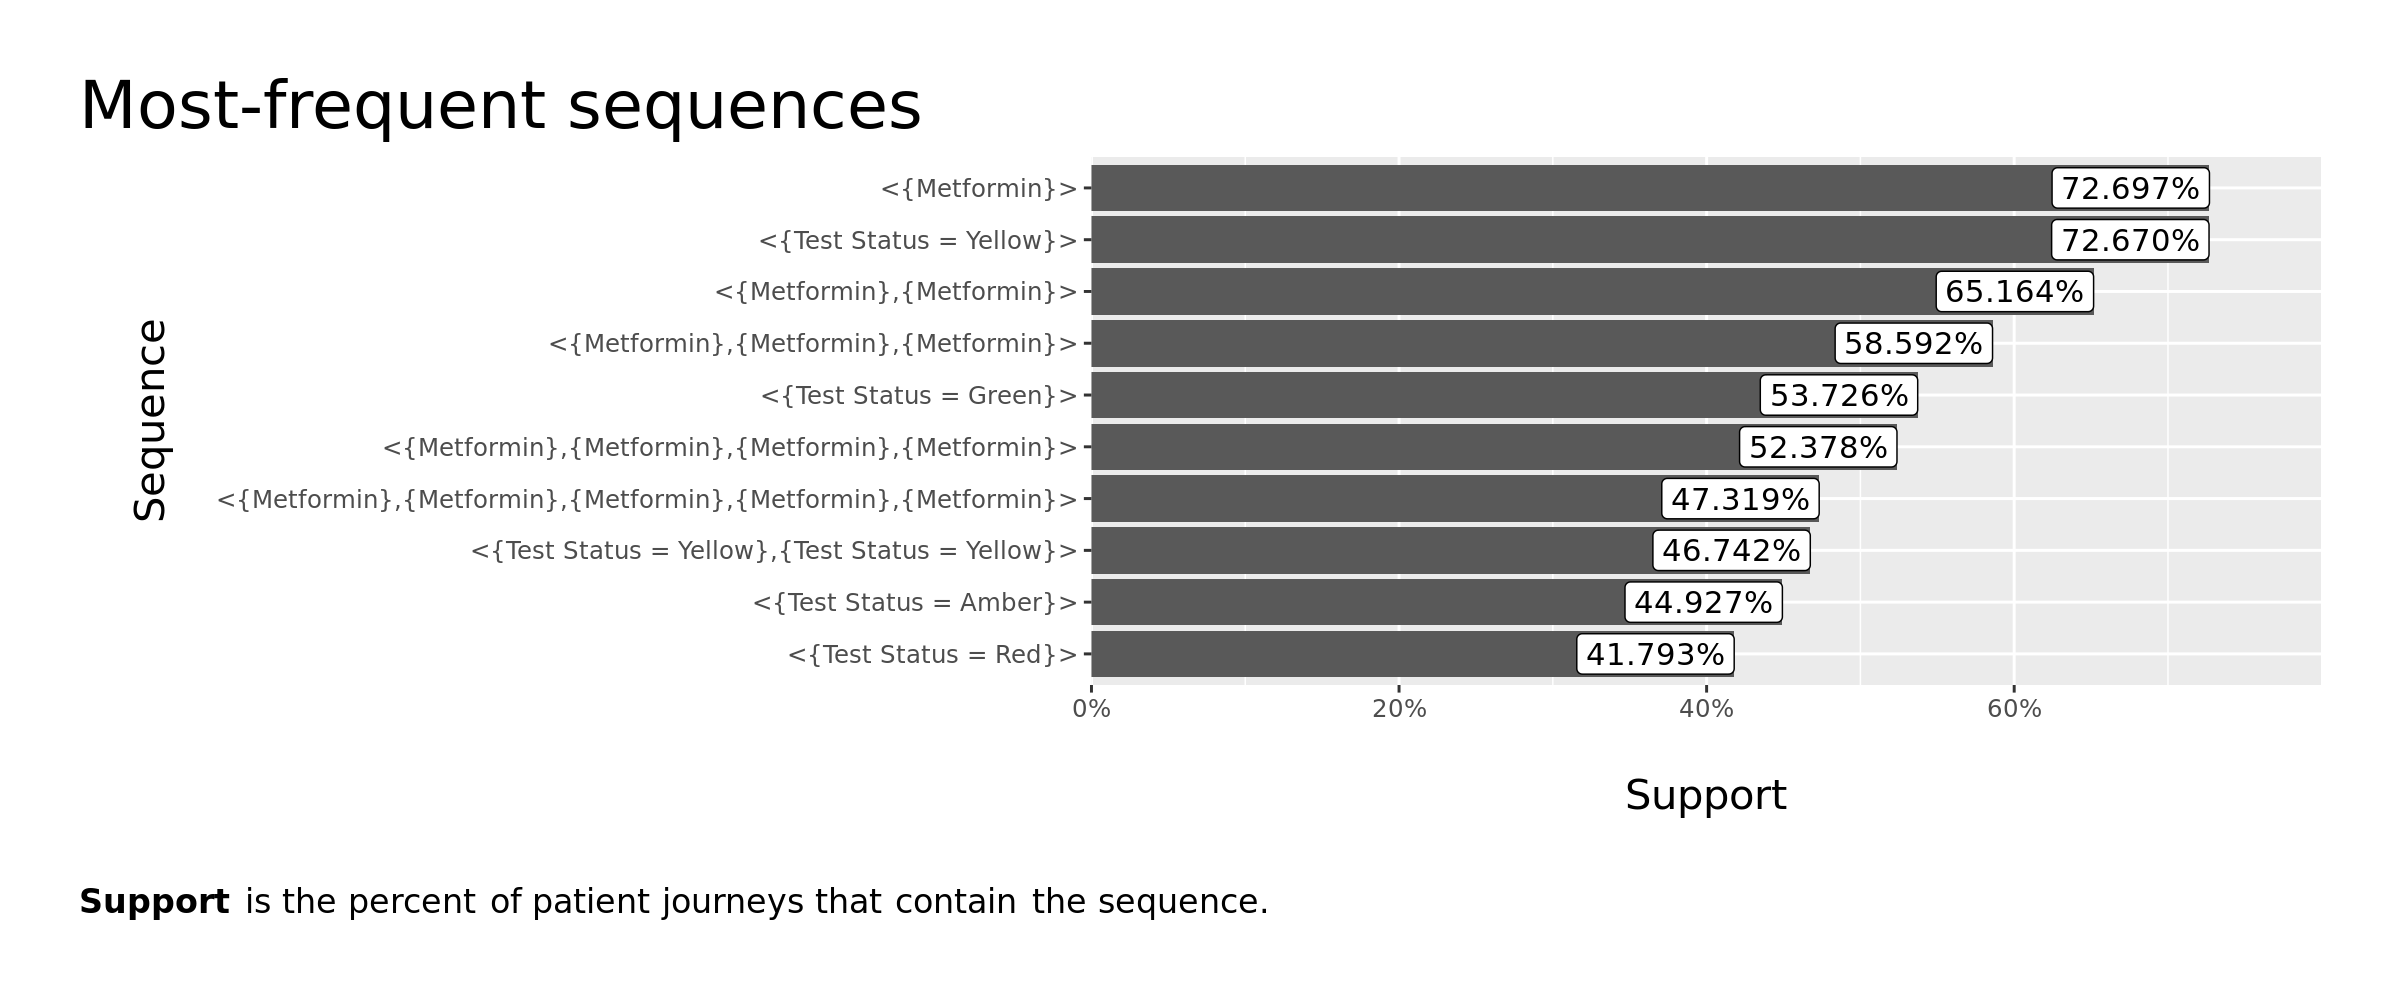

In [16]:
# Top df_itemsets Frequent Item Sets
options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200  )

df_patient_patterns %>%
    dplyr::filter(  ) %>%
    dplyr::slice_max( support, n = 10 ) %>% 
    ggplot(
        aes(
            x = fct_reorder( sequence, support )
            ,y = support
        )
    ) + 
    geom_col() +
    geom_label(
        aes(
            label = support %>% scales::percent()
        )
        ,hjust = 1
    ) + 
    labs(
        x = "Sequence"
        ,y = "Support"
        ,title = "Most-frequent sequences"
        ,caption = "**Support** is the percent of patient journeys that contain the sequence."
    ) + 
    scale_y_continuous(
        labels = scales::percent
        ,expand = expansion( mult = c( 0, .1 ) )
    ) +
    coord_flip() +
    theme(
        title = element_text( size = 20 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 12, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = "none"
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
        ,axis.title.y = element_text( margin = margin( r = 20, l = 20 ) )
        )

Induce rules based on the observed patient sequences. Each rule is scored with the following statistics:
- __Support__: The proportion of patient journeys in which $B$ directly followed $A$; $P(B|A)P(A)$
- __Confidence__: The proportion of patient journeys in which $B$ directly followed $A$, in the subset of patient journeys in which $A$ occured; $P(B|A)$
- __Lift__: A measure of association in the form of a general correlation coefficient, i.e. the quotient from dividing the co-occurence of $A$ and $B$ by the independent occurence of $A$ and $B$; $\frac{P(B|A)P(A)}{P(A)P(B)}$

Below, I show the top 10 rules with a confidence value of at least 0.6, ranked by the confidence statistic. Note that the values for the Lift statistic are almost always barely less than 1. This means that $A \to B$ is less likely than $A$ or $B$ linking with other events.

In [17]:
# Induce rules.
rules <-
    ruleInduction(set_patient_patterns, confidence = 0.6)
# Remove redundent rules.
rules <- rules[!is.redundant(rules)]

# Show rules.
df_rules <-
    as(rules, "data.frame") %>% 
    tibble::as_tibble() %>%
    separate( col = rule, into = c( 'lhs', 'rhs' ), sep = " => ", remove = F ) %>%
    dplyr::mutate( item_count = stringr::str_count(lhs, ',') ) %>%
    dplyr::arrange( -confidence, -support, -lift ) %>%
    dplyr::mutate_at(
        .vars = vars( rule )
        ,.funs = funs( stringr::str_replace_all( ., ">", "" ) )
        ) %>%
    dplyr::mutate_at(
        .vars = vars( rule )
        ,.funs = funs( stringr::str_replace_all( ., "<", "" ) )
        ) %>%
    dplyr::mutate_at(
        .vars = vars( rule )
        ,.funs = funs( stringr::str_replace( ., "\\} = \\{", "\\} \u2192 \\{" ) )
        ) %>%
    dplyr::rename(Confidence = "confidence", Lift = "lift", Support = "support") %>%
    suppressWarnings()
df_rules %>% 
    dplyr::select( lhs, rhs, Confidence, Lift, Support ) %>% 
    dplyr::mutate_if( is.numeric, ~round( .x, 2 ) ) %>%
    head( n = 10 ) 

lhs,rhs,Confidence,Lift,Support
<chr>,<chr>,<dbl>,<dbl>,<dbl>
"<{Metformin},{Metformin},{Metformin},{Metformin}>",<{Metformin}>,0.90,1.24,0.47
"<{Metformin},{Metformin}>",<{Metformin}>,0.90,1.24,0.59
<{Metformin}>,<{Metformin}>,0.90,1.23,0.65
<{Other Rx}>,<{Other Rx}>,0.86,2.35,0.32
<{Test Status = Yellow}>,<{Test Status = Yellow}>,0.64,0.89,0.47
"<{Metformin},{Test Status = Green}>",<{Test Status = Green}>,0.63,1.17,0.21
"<{Test Status = Green},{Test Status = Green}>",<{Test Status = Green}>,0.62,1.16,0.20
<{Test Status = Green}>,<{Test Status = Green}>,0.61,1.13,0.33
<{Test Status = Red}>,<{Test Status = Red}>,0.61,1.45,0.25


Visualise confidence and lift statistics.

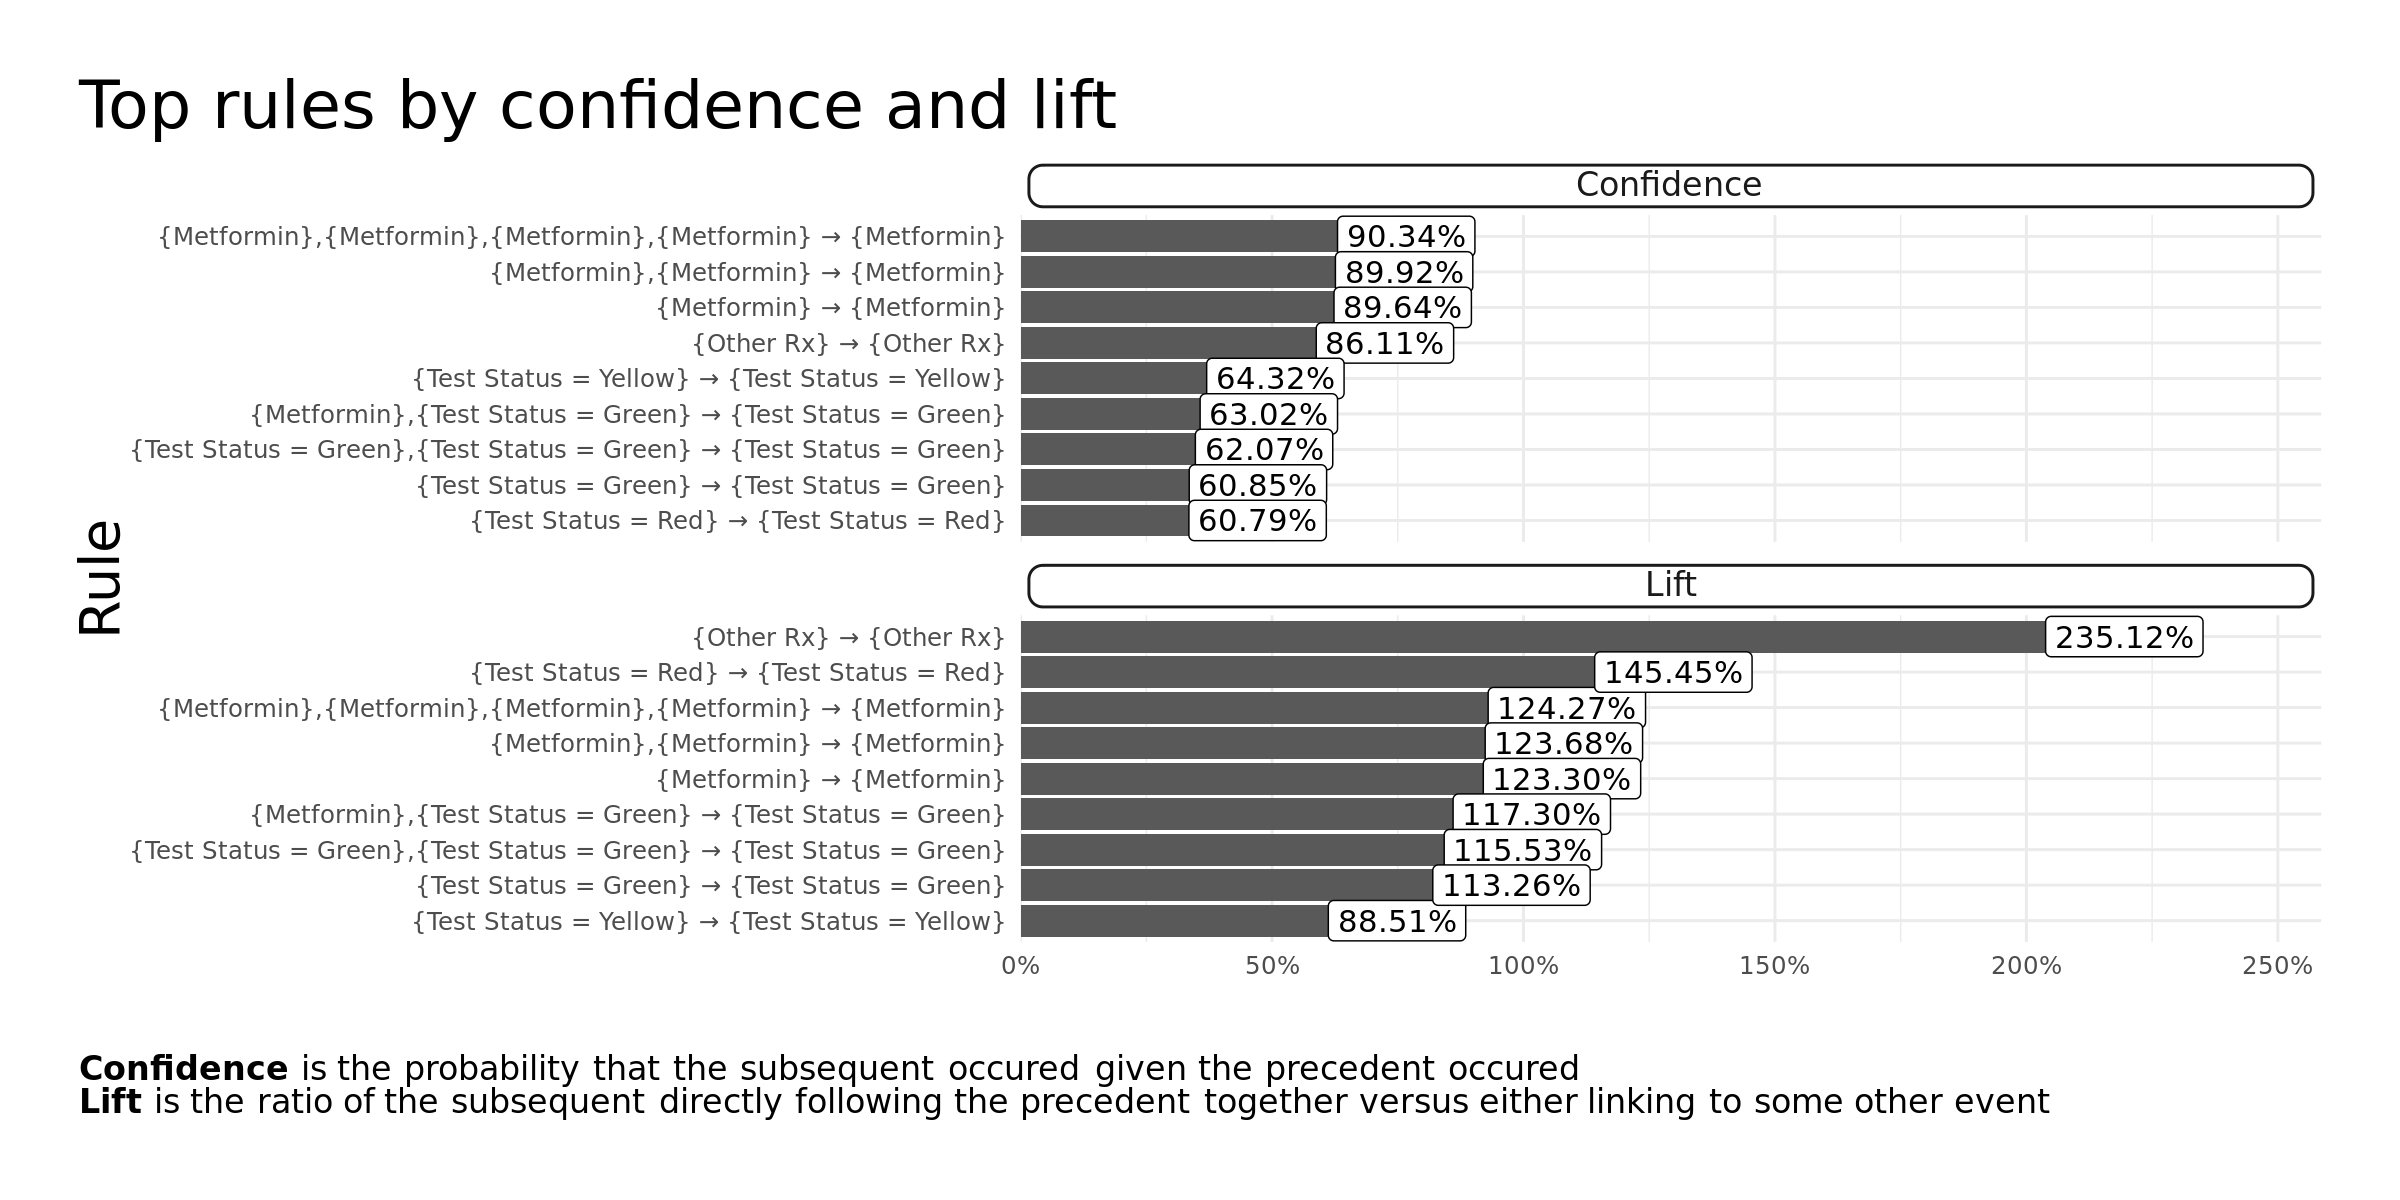

In [34]:
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )
# Make plot data.
plot_data <-
    df_rules %>% 
    # Keep only the columns I need.
    dplyr::transmute( rule, Confidence, Lift ) %>% 
    # Pivot lift and confidence into a single column.
    tidyr::pivot_longer(
      cols = c( 'Confidence', 'Lift' )
      ,names_to = "statistic"
      ,values_to = "value" ) %>% 
    dplyr::group_by( statistic ) %>% 
    # Keep only the top 10 rules for each metric.
    dplyr::top_n( n = 10, value ) %>% 
    dplyr::ungroup() %>% 
    # Round the numbers
    dplyr::mutate_if( is.numeric, ~round( .x, 4 ) )

# Set maximum x-axis range.
myxrange <- max( max(df_rules$Confidence), max(df_rules$Lift))

# Plot plot data.
plot_data %>% 
    ggplot(
      aes(
          x = tidytext::reorder_within( rule, value, statistic )
          ,y = value
      )
    ) + 
        geom_col() + 
        geom_label(
            aes(
                label = value %>% scales::percent()
            )
            ,hjust = 1 ) +
        tidytext::scale_x_reordered() + 
        scale_y_continuous( label = scales::percent
                            #,limits = c( 0, myxrange )
                            ,expand = expansion( mult = c( 0, .1 )
                                              )
                          ) + 
        labs(
            x = "Rule"
            ,y = ""
            ,title = "Top rules by confidence and lift"
            ,caption = "**Confidence** is the probability that the subsequent occured given the precedent occured <br />
                       **Lift** is the ratio of the subsequent directly following the precedent together versus either linking to some other event") +
        facet_wrap( ~statistic, ncol = 1, scales = "free_y" ) +
        coord_flip() +
        theme_minimal() +
        theme(
            plot.title.position = 'plot'
            ,title = element_text( size = 20 )
            ,plot.caption.position = 'plot'
            ,plot.caption = ggtext::element_markdown( size = 12, hjust = 0)
            ,legend.position = "none"
            ,plot.margin = unit( c(1, 1, 1, 1), "cm")
            ,strip.text = ggtext::element_textbox(
                size = 12
                ,halign = 0.5
                ,linetype = 1
                ,r = unit( 5, "pt" )
                ,width = unit( 1, "npc" )
                ,padding = margin(2, 0, 1, 0)
                ,margin = margin(3, 3, 3, 3)
            )
        )

#### TraMineR

Plot the top-10 most-frequent patient journeys.

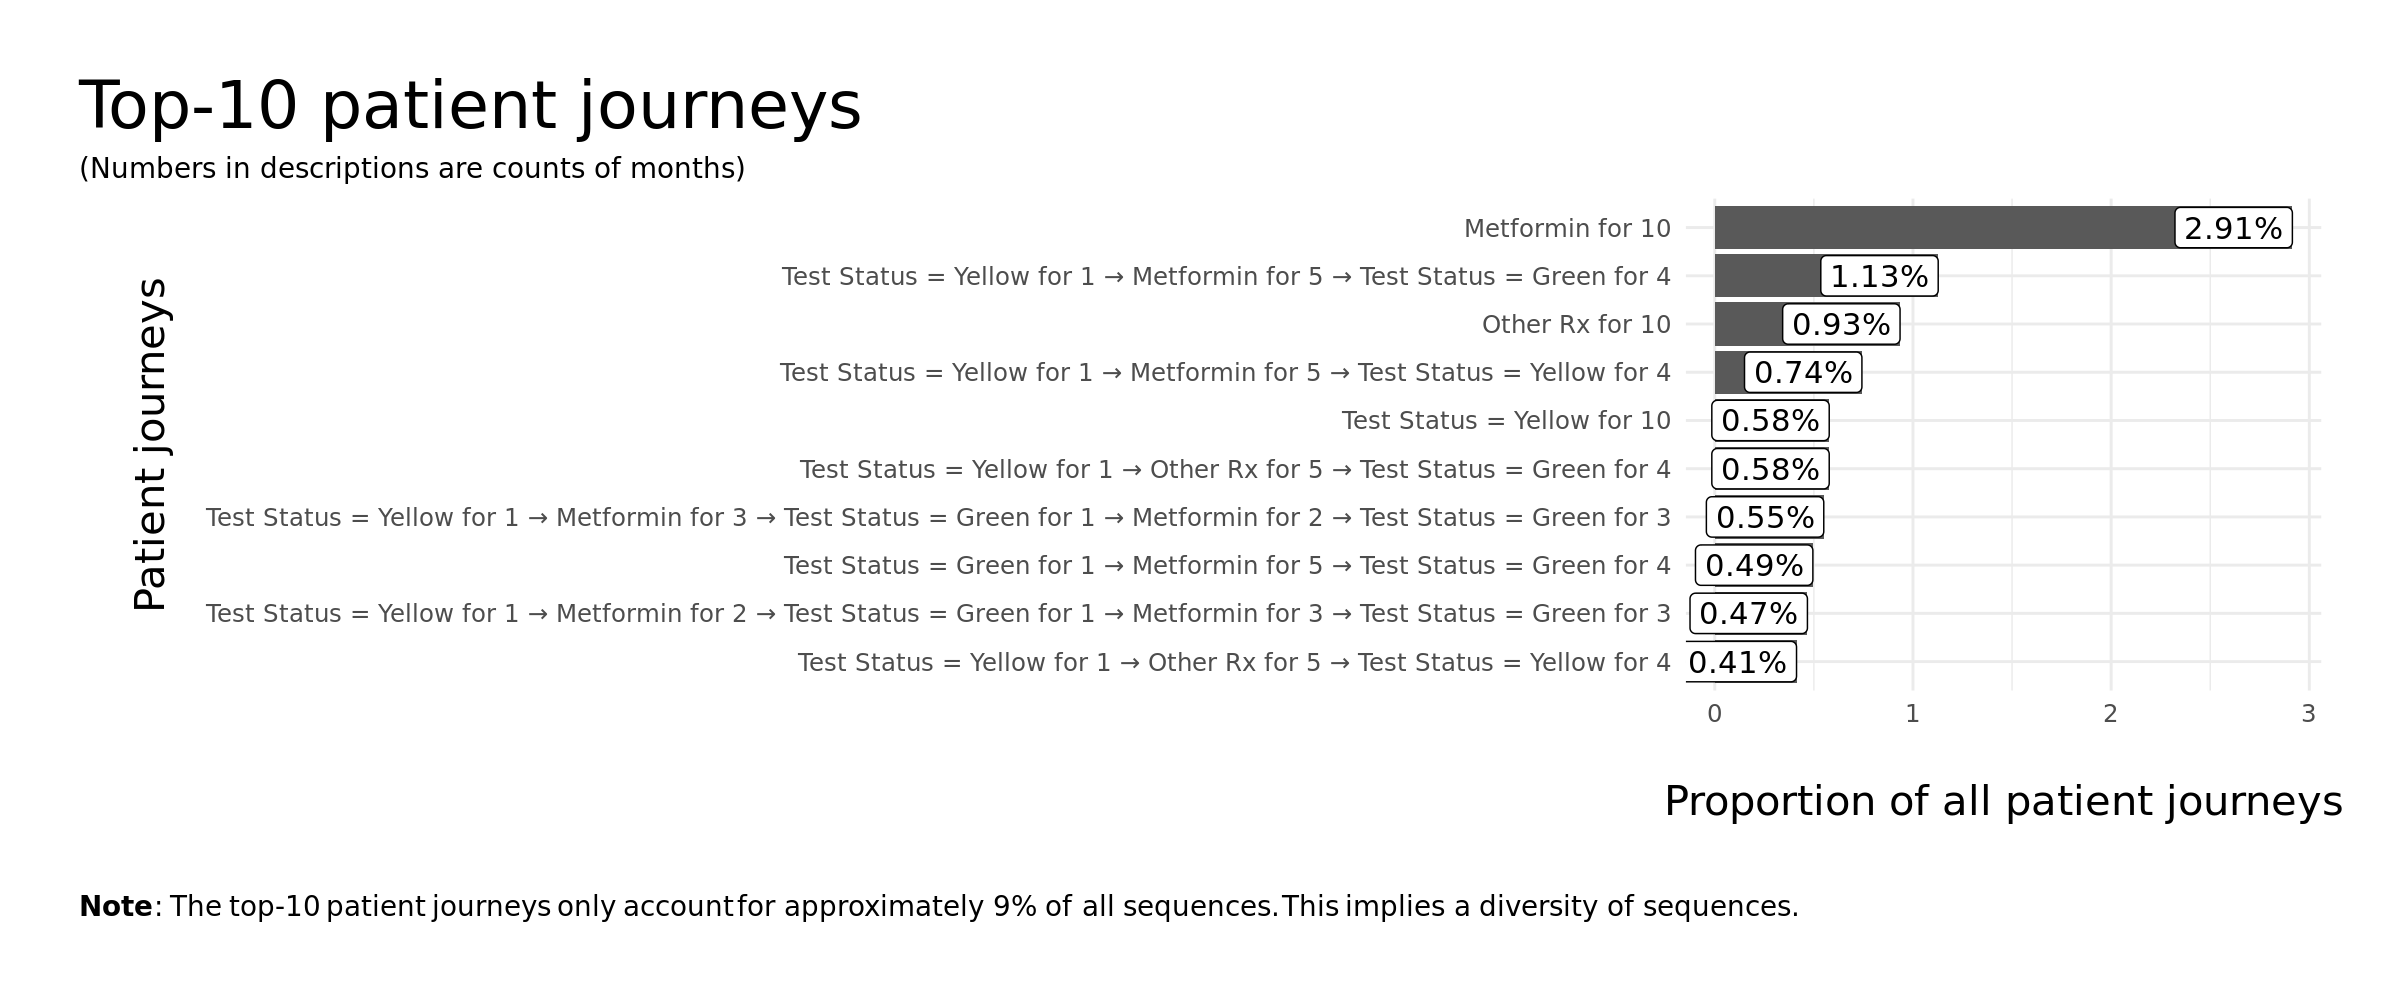

In [23]:
options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

# Make plot data.
plot_data <-
    TraMineR::seqtab( sts_seqmine ) %>%
    attributes() %>%
    purrr::pluck( "freq" ) %>%
    tibble::rownames_to_column( "sequence" ) %>%
    dplyr::arrange( desc( Freq ) ) %>%
    dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
    # Remove the leading "None/[0-9]"
    dplyr::mutate_at(
        .vars = vars( sequence )
        ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
        ) %>%
    # Replace the "-" that joins the events with an arrow.
    dplyr::mutate_at(
        .vars = vars( sequence )
        ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
        ) %>%
    # Use words instead of symbols for the number of timesteps.
    dplyr::mutate_at(
        .vars = vars( sequence )
        ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
        ) %>%
    suppressWarnings()


# Plot plot data.
plot_data %>%
    ggplot(
        aes(
            x = reorder( sequence, Freq )
            ,y = Percent )
        , stat = "identity"
    ) +
    geom_col() +
    geom_label(
            aes(
                label = Percent %>% `/`(100) %>% round(4) %>% scales::percent()
            )
            ,hjust = 1 ) +
    coord_flip() +
    labs(
        x = "Patient journeys"
        ,y = "Proportion of all patient journeys"
        ,title = "Top-10 patient journeys"
        ,subtitle = "(Numbers in descriptions are counts of months)"
        ,caption = paste0(
            "**Note**: The top-10 patient journeys only account for approximately "
            ,round( max( plot_data$cum_sum_percent ))
                   ,"% of all sequences. This implies a diversity of sequences."
                  )
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = "none"
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
        ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
        )

Below are the month-by-month relative propotions of each event, across all patient journeys.

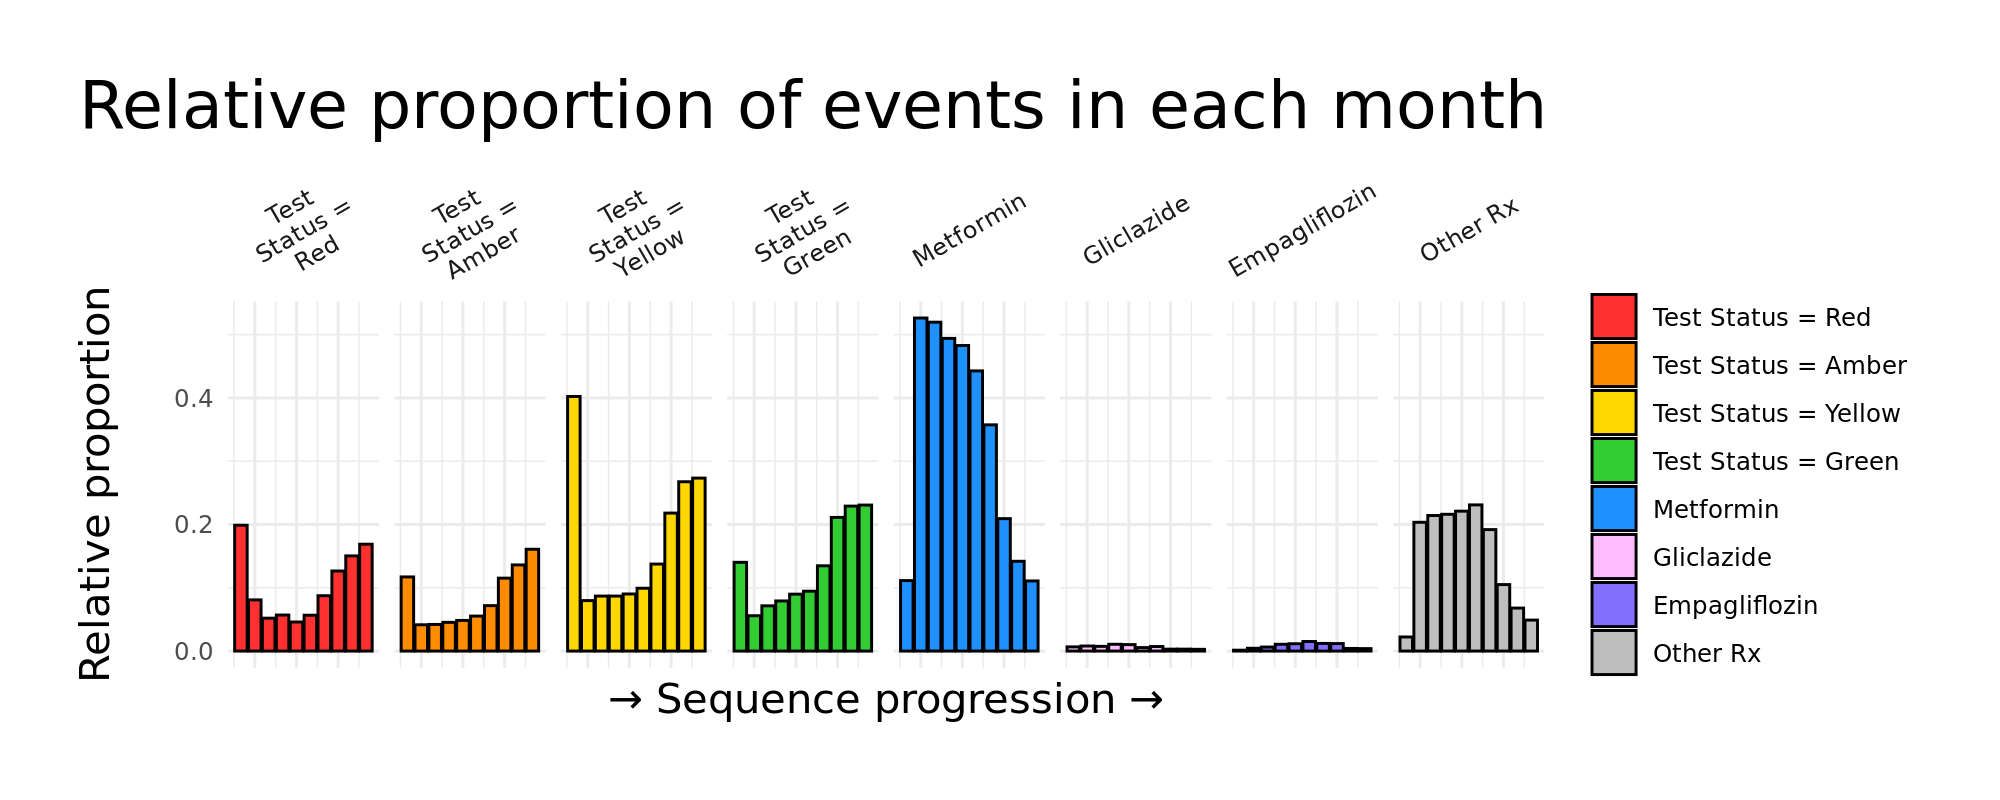

In [34]:
options( repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200 )

# Prepare plot data.
plot_data <-
    TraMineR::seqstatd( sts_seqmine ) %>%
    purrr::pluck( "Frequencies" ) %>%
    as.data.frame() %>%
    tibble::rownames_to_column( "event" ) %>%
    dplyr::filter( event != "None" ) %>%
    dplyr::select( -a1 ) %>%
    tidyr::pivot_longer(
        cols = !event
        ,names_to = "month"
        ,values_to = "proportion"
    ) %>%
    dplyr::mutate_at(
        .vars = vars( event )
        ,.funs = funs( factor(., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1) ) )
    ) %>%
    dplyr::mutate_at(
        .vars = vars( month )
        ,.funs = funs( stringr::str_replace_all( ., "a", "" ) %>% as.integer() )
    ) %>%
    suppressWarnings()

# Plotting.
plot_data %>%
ggplot() +
geom_bar(
    aes(
        x = month
        ,y = proportion
        ,fill = event
    )
    ,stat = "identity"
    ,colour = "black"
) +
scale_fill_manual( values = df_event_factor %>% dplyr::select( event_colours_order ) %>% dplyr::pull(1) ) +
labs(
    x = "\u2192 Sequence progression \u2192"
    ,y = "Relative proportion"
    ,title = "Relative proportion of events in each month"
) +
facet_wrap( ~ event, nrow = 1, labeller = label_wrap_gen( width = 10) ) +
theme_minimal() +
theme(
    title = element_text( size = 20 )
    ,plot.subtitle = element_text( size = 10 )
    ,axis.title = element_text( size = 15 )
    ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
    ,plot.caption.position = 'plot'
    ,plot.title.position = 'plot'
    ,axis.text.x = element_blank()
    ,legend.title = element_blank()
    ,plot.margin = unit( c(1, 1, 1, 1), "cm")
    ,axis.title.y = element_text( margin = margin( r = 20 ) )
    ,strip.text = element_text(angle = 30)
    )

Average duration that a patient spends in a "state" without changing.

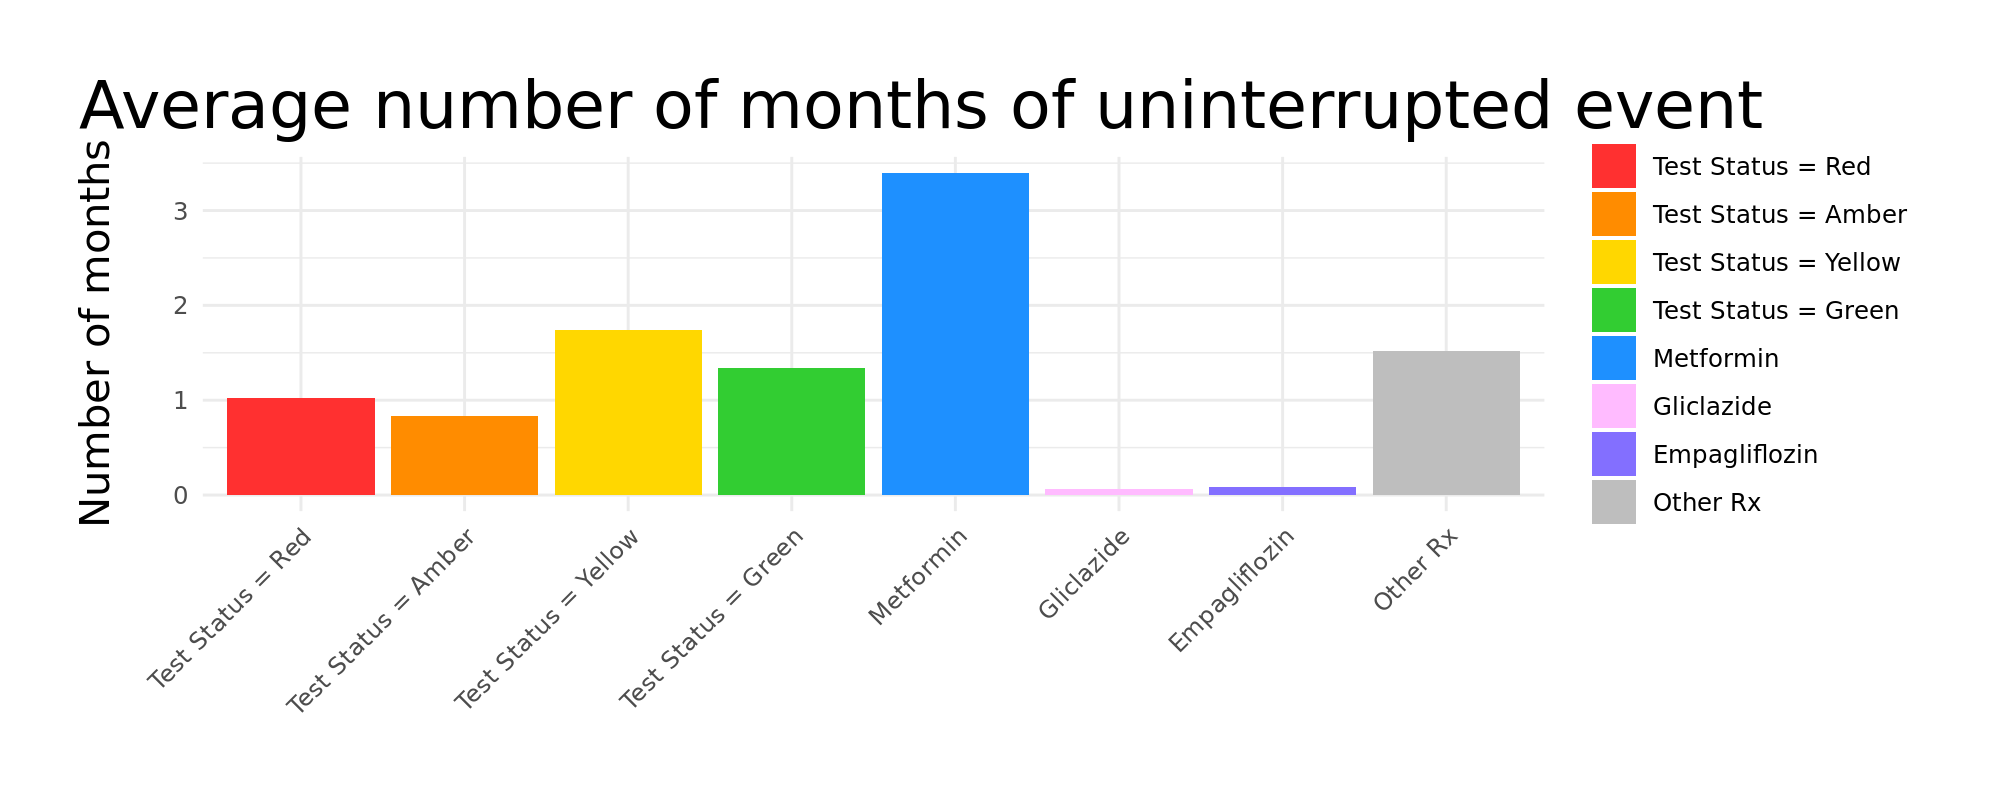

In [25]:
TraMineR::seqmeant( sts_seqmine ) %>%
as.data.frame() %>%
tibble::rownames_to_column("event") %>%
dplyr::left_join(
    df_event_factor
    ,by = join_by( event == event_fct_order)
) %>%
dplyr::mutate_at(
    .vars = vars( event )
    ,.funs = funs( factor(., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1) ) )
) %>%
suppressWarnings() %>%
dplyr::filter( event != "NA" ) %>%
ggplot() +
geom_bar(
    aes(
        x = event
        ,y = Mean
        ,fill = event
    )
    ,stat = "identity" ) +
scale_fill_manual( values = df_event_factor %>% dplyr::select( event_colours_order ) %>% dplyr::pull(1) ) +
labs(
    title = "Average number of months of uninterrupted event"
    ) +
ylab( "Number of months" ) +
theme_minimal() +
theme(
    title = element_text( size = 20 )
    ,plot.subtitle = element_text( size = 10 )
    ,axis.title = element_text( size = 15 )
    ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
    ,plot.caption.position = 'plot'
    ,plot.title.position = 'plot'
    ,axis.text.x = element_text( angle = 45, hjust = 1 )
    ,axis.title.x = element_blank()
    ,plot.margin = unit( c(1, 1, 1, 1), "cm")
    ,axis.title.y = element_text( margin = margin( r = 20 ) )
    ,legend.title = element_blank()
    )


Calculate statistics that summarise and represent the complicatedness / complexity of patients' sequences, then plot as histograms.

_Component_

- The __Transitions Count__ statistic is the count of times a patient changes state during their sequence. It has an unbounded range and does not take the length of the sequence into account (i.e. low counts can indicate short sequences with little time to change state, or can indicate a long and stable sequence).
- The __$\mathbf{log_{2}}(Subsequence Count)$__ statistics is the  $log_{2}$ of the count of 'distinct successive states' during a patient's sequence. It has an unbounded range with a sequence-specific maximum reached when the sequence cycles between all its states. Low values can indicate either few changes or a small number of unique states observed in the sequence.
- The __Longitudinal Entropy__ statistic quantifies the entropy of the distribution of durations spent in each state observed in the sequence. It is a measure of diversity of states within a sequence, and is exactly the longituindal Shannon entropy. It's range is between 0 and 1 because each sequence's value is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet).

_Composite_

- The __Turbulence__ statistic is the $log_{2}$ of the product of the count of subsequences and a sequence-specific scaling parameter ([Elzinga et al. 2007](https://sci-hub.wf/10.1007/s10680-007-9133-7)). The sequence-specific scaling parameter is based on the variance of observed state durations (which we know to be inversely propotional to the notion of turbulent sequences). Larger values are associated with sequences that have many states, changes, and similar durations in each state. This statistic differs from the $\mathbf{log_{2}}(Subsequence Count)$ only by the sequence-specific scaling parameter within the $log_{2}$ operator.
- The __Complexity Index__ statistic is the geometric mean of a scaled count of transitions in a sequence and the sequence's scaled longitudinal entropy ([Gabadinho et al. 2010](https://www.researchgate.net/profile/Gilbert-Ritschard/publication/220786242_Indice_de_complexite_pour_le_tri_et_la_comparaison_de_sequences_categorielles/links/53edabdb0cf26b9b7dc5f259/Indice-de-complexite-pour-le-tri-et-la-comparaison-de-sequences-categorielles.pdf)). The count of transitions is scaled to the length of the sequence, and the longitundinal entropy is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet). It's range is between 0 and 1.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


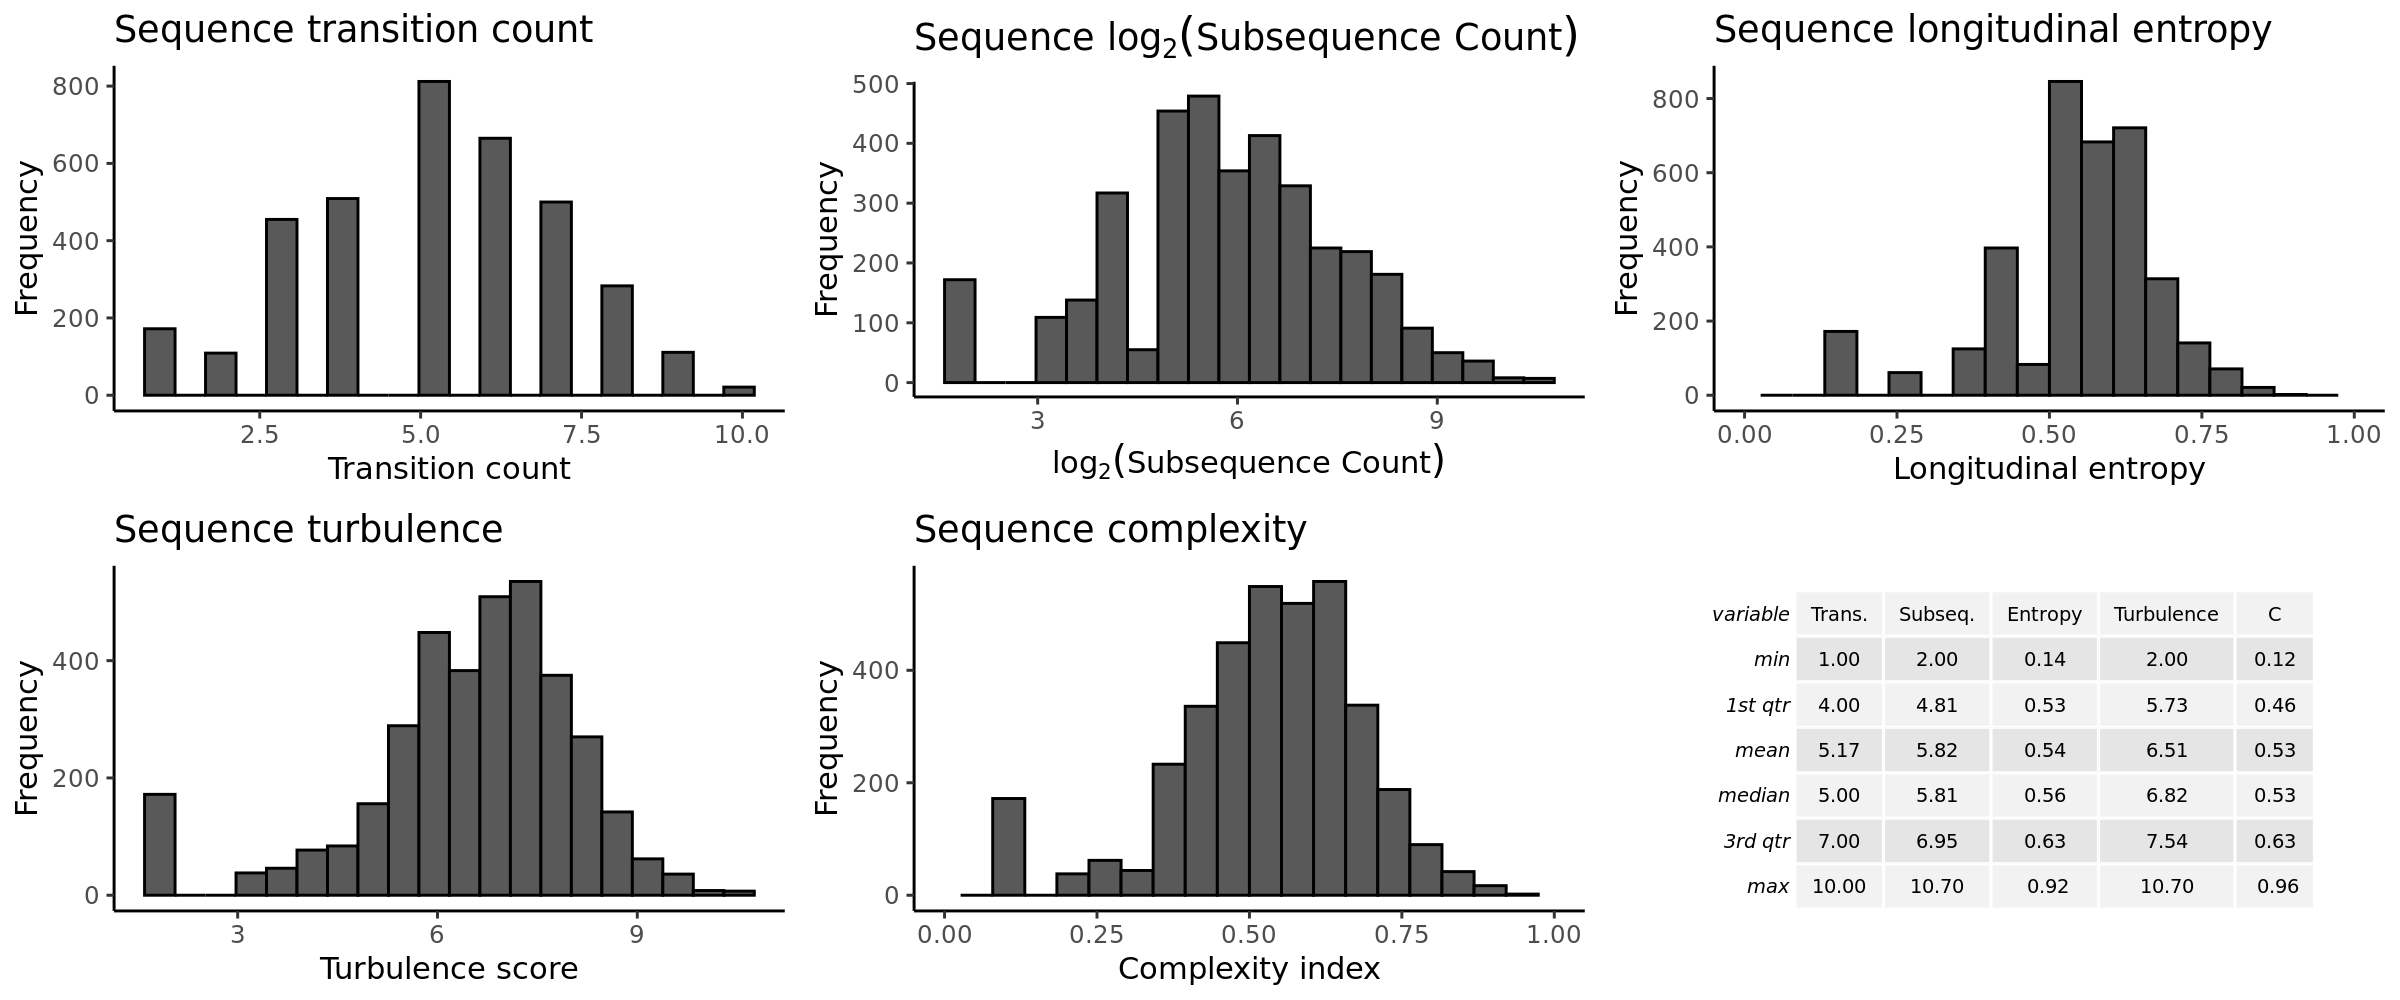

In [26]:
# Calculate statistics over all patient records.
seq_transitionCount <- TraMineR::seqtransn( sts_seqmine )
seq_subsequenceCount <- TraMineR::seqsubsn( sts_seqmine ) %>% log( base = 2 )
seq_longEntropy <- TraMineR::seqient( sts_seqmine )
seq_turbulence <- TraMineR::seqST( sts_seqmine )
seq_complexity <- TraMineR::seqici( sts_seqmine )

# Plot histograms and summary statistics
n_bins = 20
# ## Create plots.
hist_trans <-
    seq_transitionCount %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( Trans. ), bins = n_bins, colour = "black") +
    labs( title = "Sequence transition count", x = "Transition count", y = "Frequency" ) +
    theme_classic()
hist_subseq <-
    seq_subsequenceCount %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( Subseq. ), bins = n_bins, colour = "black") +
    labs( title = base::bquote("Sequence "*log[2]("Subsequence Count")) , x = base::bquote(log[2]("Subsequence Count")), y = "Frequency" ) +
    theme_classic()
hist_entr <-
    seq_longEntropy %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( Entropy ), bins = n_bins, colour = "black") +
    labs( title = "Sequence longitudinal entropy", x = "Longitudinal entropy", y = "Frequency" ) +
    xlim( 0, 1 ) +
    theme_classic()
hist_turb <-
    seq_turbulence %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( Turbulence ), bins = n_bins, colour = "black") +
    labs( title = "Sequence turbulence", x = "Turbulence score", y = "Frequency" ) +
    theme_classic()
hist_cidx <-
    seq_complexity %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black") +
    labs( title = "Sequence complexity", x = "Complexity index", y = "Frequency" ) +
    xlim( 0, 1 ) +
    theme_classic()
# ## Create table of summary statistics.
plot_table <-
seq_transitionCount %>%
dplyr::bind_cols( seq_subsequenceCount, seq_longEntropy, seq_turbulence, seq_complexity ) %>%
dplyr::summarise(
    across(
        everything()
        ,list(
            min = min
            ,`1st qtr` = ~quantile( ., 0.25 )
            ,mean = mean
            ,median = median
            ,`3rd qtr` = ~quantile( ., 0.75 )
            ,max = max
        )
    )
) %>%
base::round(2) %>%
pivot_longer(
    everything()
    ,names_sep = '_'
    ,names_to = c( 'variable', '.value' )
) %>%
t() %>%
gridExtra::tableGrob( theme = gridExtra::ttheme_default( base_size = 7) )

# ## Plot.
options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )
gridExtra::grid.arrange(
    gridExtra::arrangeGrob(
        hist_trans, hist_subseq, hist_entr, hist_turb, hist_cidx, plot_table
        ,ncol = 3
    )
)

### 1.4.2 Build simulation models, if applicable
Not applicable for this iteration.

### 1.4.3 Design and test model evaluation rig
Not applicable for this iteration.
### 1.4.4 Set up and/or update the evidence template
Not applicable for this iteration.

## Stage 5: Evaluation
This tasks for this stage are:
1. Meet with Clinical Review Board to assess validity.
2. Set requirements for next interation of stages 1-5.

### 1.5.1. Meet with Clinical Review Board to assess validity
Notes from Clinical Review Board on 29th February 2024:
- The research question is still valid, but some stratification would be insightful.
- Two possibly-insightful stratifications are:
    - R.A.M.E.: Four strata defined by combinations of {'Expected', 'Shorter-than-expected'} testing intervals and {'No observed change', 'Observed change'} in prescriptions. The R.A.M.E. acronym derives from the four strata: (0,0)-Run; (0,1)-Adjust; (1,0)-Monitor; (1,1)-Escalate.
    - test-and-poly: Twelve strata defined by combinations of the test statuses and whether the patient is on one, two or three medications simulatneously.
- It would be more useful to separate the test statuses from the prescriptions because they help to answer two distinct questions, i.e. _how do the relative proportions of test statuses change over time?_ and _how do the relative proportions of prescriptions change over time?_

### 1.5.2 Set requirements for next interation of stages 1-5.
Requirements for the next iteration are:
1. Encode new variables that indicate the membership to strata suggested by the Clinical Review Board.
2. Reapply the analysis plan but stratify output.
3. Create the requested Sankey diagram.